# Random Number Lab I

In this lab, we will practice generating random numbers from the standard normal distribution in two ways:
1. Inverse Transform Method (via the error function).
2. Rejection (Acceptance–Rejection) Method, using a uniform proposal distribution on a finite interval.

Although Python (and NumPy) provides the built-in `np.random.normal()` for Gaussian sampling, understanding these two methods sheds light on how more general sampling algorithms can be constructed and gives insight into the internal workings of random number generation for non-uniform distributions.

## Inverse Transform Method for the Normal Distribution

The inverse transform method uses the fact that if $X$ has a continuous probability distribution with cumulative distribution function (CDF) $F(x)$, then $U = F(X)$ is uniformly distributed on $[0,1)$.
Reversing this logic, if $U$ is uniform on $[0,1)$, then
\begin{align}
X = F^{-1}(U)
\end{align}
follows the distribution with CDF $F(x)$.
For many distributions (e.g., exponential), we can find a simple closed-form inverse for $F$. However, the standard normal CDF $\Phi(x)$ does not have an elementary closed-form inverse.
Instead, it can be written in terms of the error function `erf()`.

For a standard normal distribution, the CDF is
\begin{align}
\Phi(x) = \frac{1}{2}\Bigl(1 + \mathrm{erf}\bigl(\frac{x}{\sqrt{2}} \bigr)\Bigr).
\end{align}
Hence, the inverse is expressible with the inverse error function:
\begin{align}
\Phi^{-1}(u) = \sqrt{2}\,\mathrm{erfinv}\bigl(2u - 1\bigr).
\end{align}
Thus, if $U \sim \mathrm{Uniform}(0,1)$, then
\begin{align}
X = \sqrt{2}\,\mathrm{erfinv}\bigl(2U - 1\bigr)
\end{align}
is a sample from the standard normal distribution.

In [9]:
import numpy as np
import scipy

def inverse(size=10000):
    return np.sqrt(2) * scipy.special.erfinv(2*size-1)

In [10]:
U = np.random.rand(10000)
X = inverse(U)

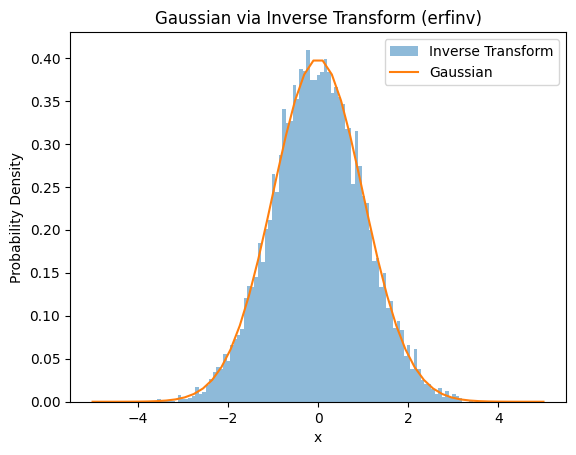

In [11]:
import matplotlib.pyplot as plt

xs = np.linspace(-5, 5)
ys = np.exp(-xs*xs/2) / np.sqrt(2 * np.pi)

plt.hist(X, bins=100, density=True, alpha=0.5, label='Inverse Transform')
plt.plot(xs, ys, label='Gaussian')
plt.title('Gaussian via Inverse Transform (erfinv)')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

## Rejection Method for the Normal Distribution

The rejection (acceptance–rejection) method requires:
1. A target PDF $f(x)$ we want to sample.
   Here, that is the standard normal:
   \begin{align}
   f(x) = \frac{1}{\sqrt{2\pi}}\, e^{-x^2/2}.
   \end{align}
3. A proposal PDF $g(x)$ from which it is easy to sample.
4. A constant $C$ such that
   \begin{align}
   f(x) \le C\,g(x) \quad \text{for all }x.
   \end{align}

We will restrict $x$ to a finite range, say [-5,5], where the normal PDF is effectively concentrated (its tails beyond $\pm 5$ are extremely small).
Our proposal distribution is a uniform distribution on $[-5,5]$, so
\begin{align}
g(x) = \frac{1}{10}, \quad x \in [-5,5].
\end{align}
We then need $C$ so that $f(x)\le C\,g(x)$.
Since $g(x)=1/10$, we need
\begin{align}
f(x) \le C \times \frac{1}{10}.
\end{align}
The maximum of $f(x)$ for the standard normal occurs at $x=0$, where $f(0)=\frac{1}{\sqrt{2\pi}}\approx 0.3989$.
Thus, we need $C/10 \ge 0.3989$, or $C \ge 3.989$.
We can safely choose $C = 4.0$ or $C=5.0$ for simplicity.

In [25]:
def normal_pdf(x):
    return 1/(np.sqrt(2*np.pi))*np.exp(-0.5*x**2)

def rejection(size=10000, bound=5, C=5.0):
    samples = []
    n_draws = 0
    while len(samples) < size:
        # Step 1: draw from proposal Uniform(0,5)
        x_prop = 5 * np.random.rand()
        
        # Step 2: draw a uniform U in [0,1)
        U = np.random.rand()
        
        # Step 3: accept/reject
        # Accept if U <= f(x_prop) / (C*g(x_prop)) = f(x_prop) / (C*(1/5)) = [5*f(x_prop)] / C
        if U <= (5 * normal_pdf(x_prop) / C):
            samples.append(x_prop)
        n_draws += 1
    
    acc_ratio = size / n_draws
    return np.array(samples), acc_ratio

In [26]:
# Run the rejection sampler
Xrej, acception_ratio = rejection()

print(f"Acceptance Ratio = {acception_ratio:.2f}")

Acceptance Ratio = 0.10


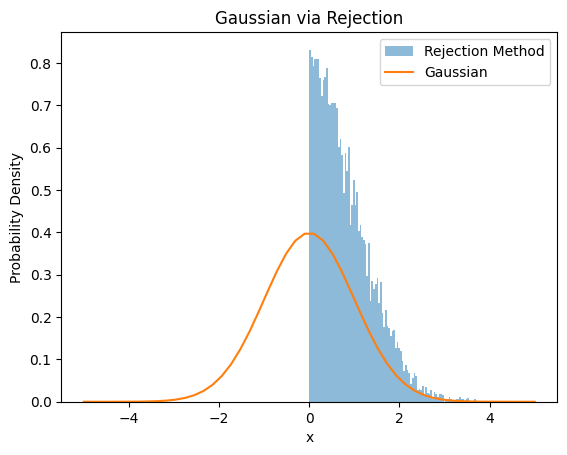

In [27]:
plt.hist(Xrej, bins=100, density=True, alpha=0.5, label='Rejection Method')
plt.plot(xs, ys, label='Gaussian')
plt.title('Gaussian via Rejection')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()